# Preliminary analysis of the dataset

In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

import utils
import os

import glob
import random

%matplotlib inline

## Visualization of the images

Observatory,SDO
Instrument,AIA 2
Detector,AIA
Measurement,211.0 Angstrom
Wavelength,211.0 Angstrom
Observation Date,2015-12-28 03:16:46
Exposure Time,2.901205 s
Dimension,[256. 256.] pix
Coordinate System,helioprojective
Scale,[9.612128 9.612128] arcsec / pix
Reference Pixel,[126.73562625 126.94625094] pix

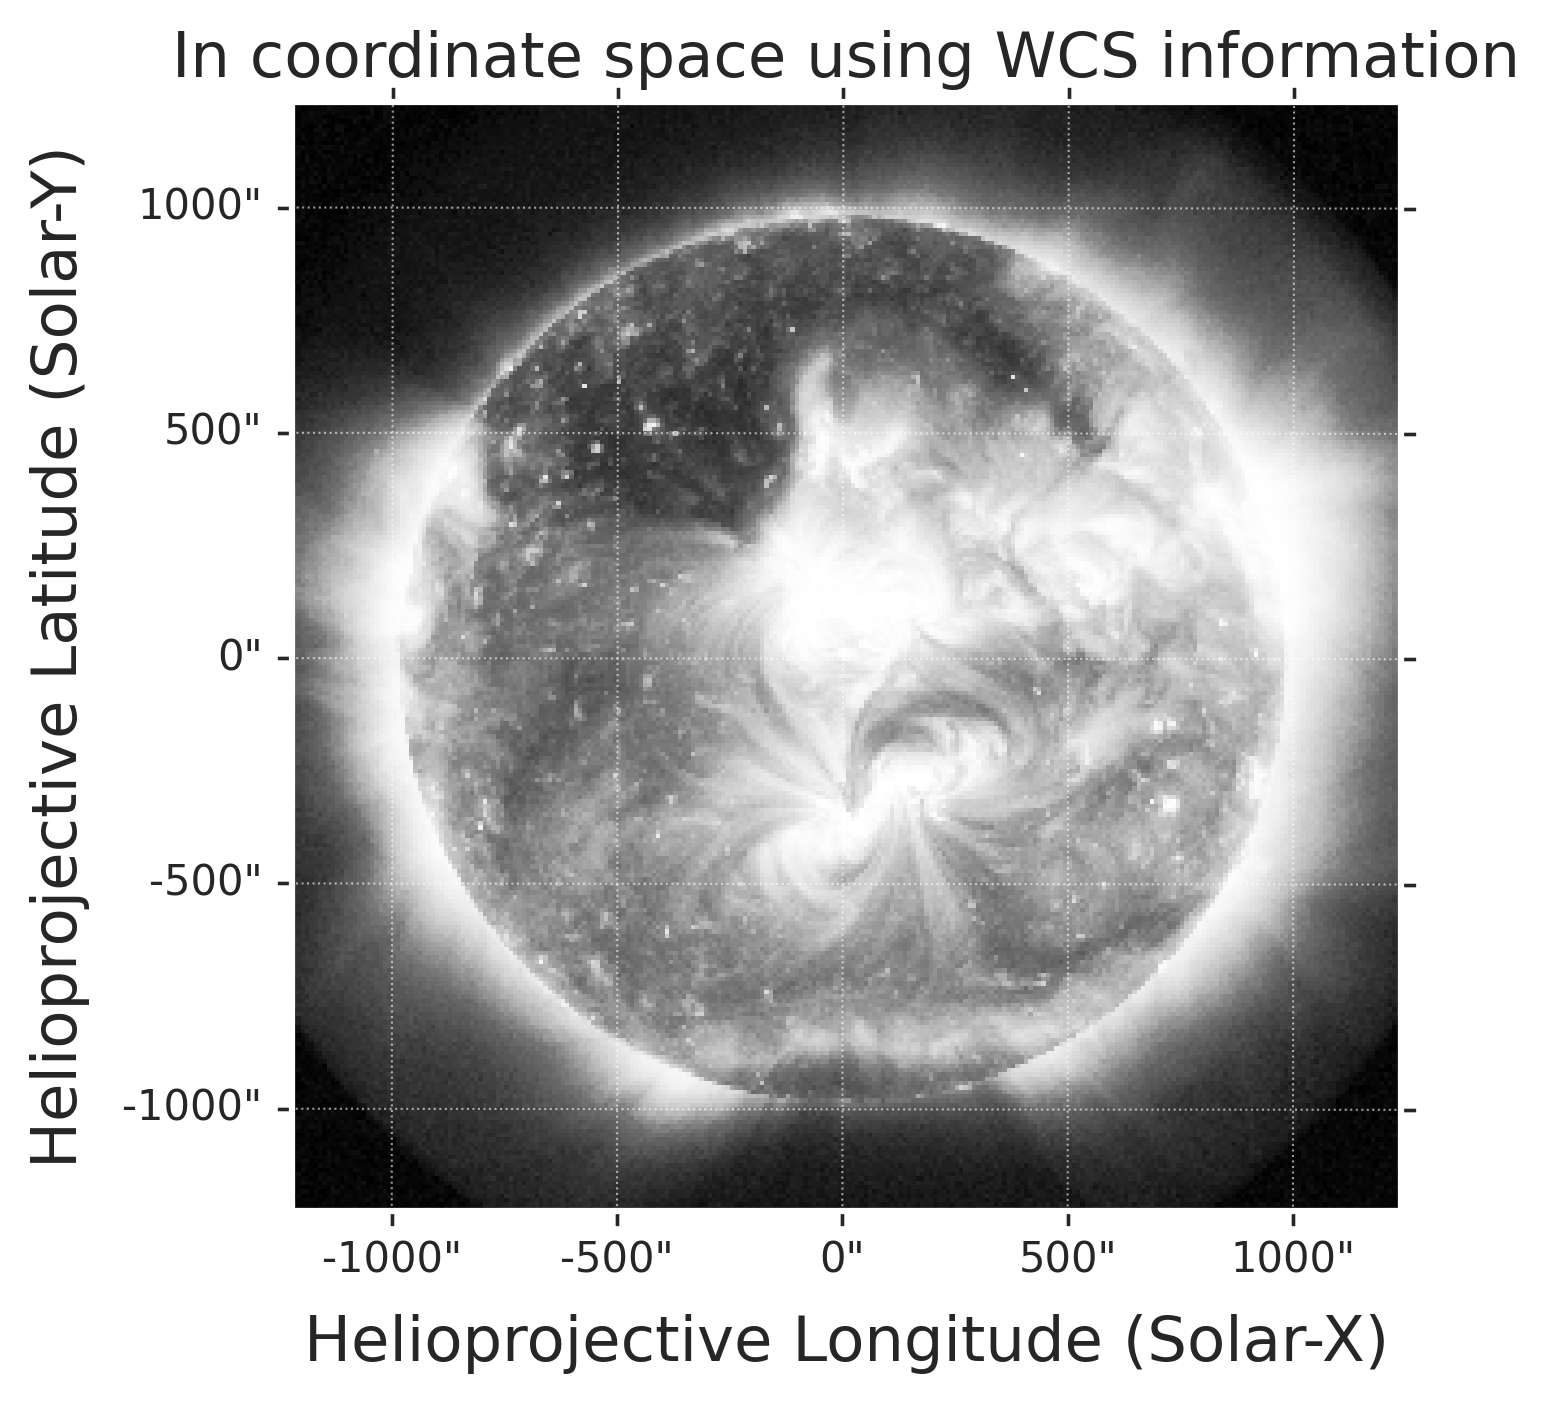
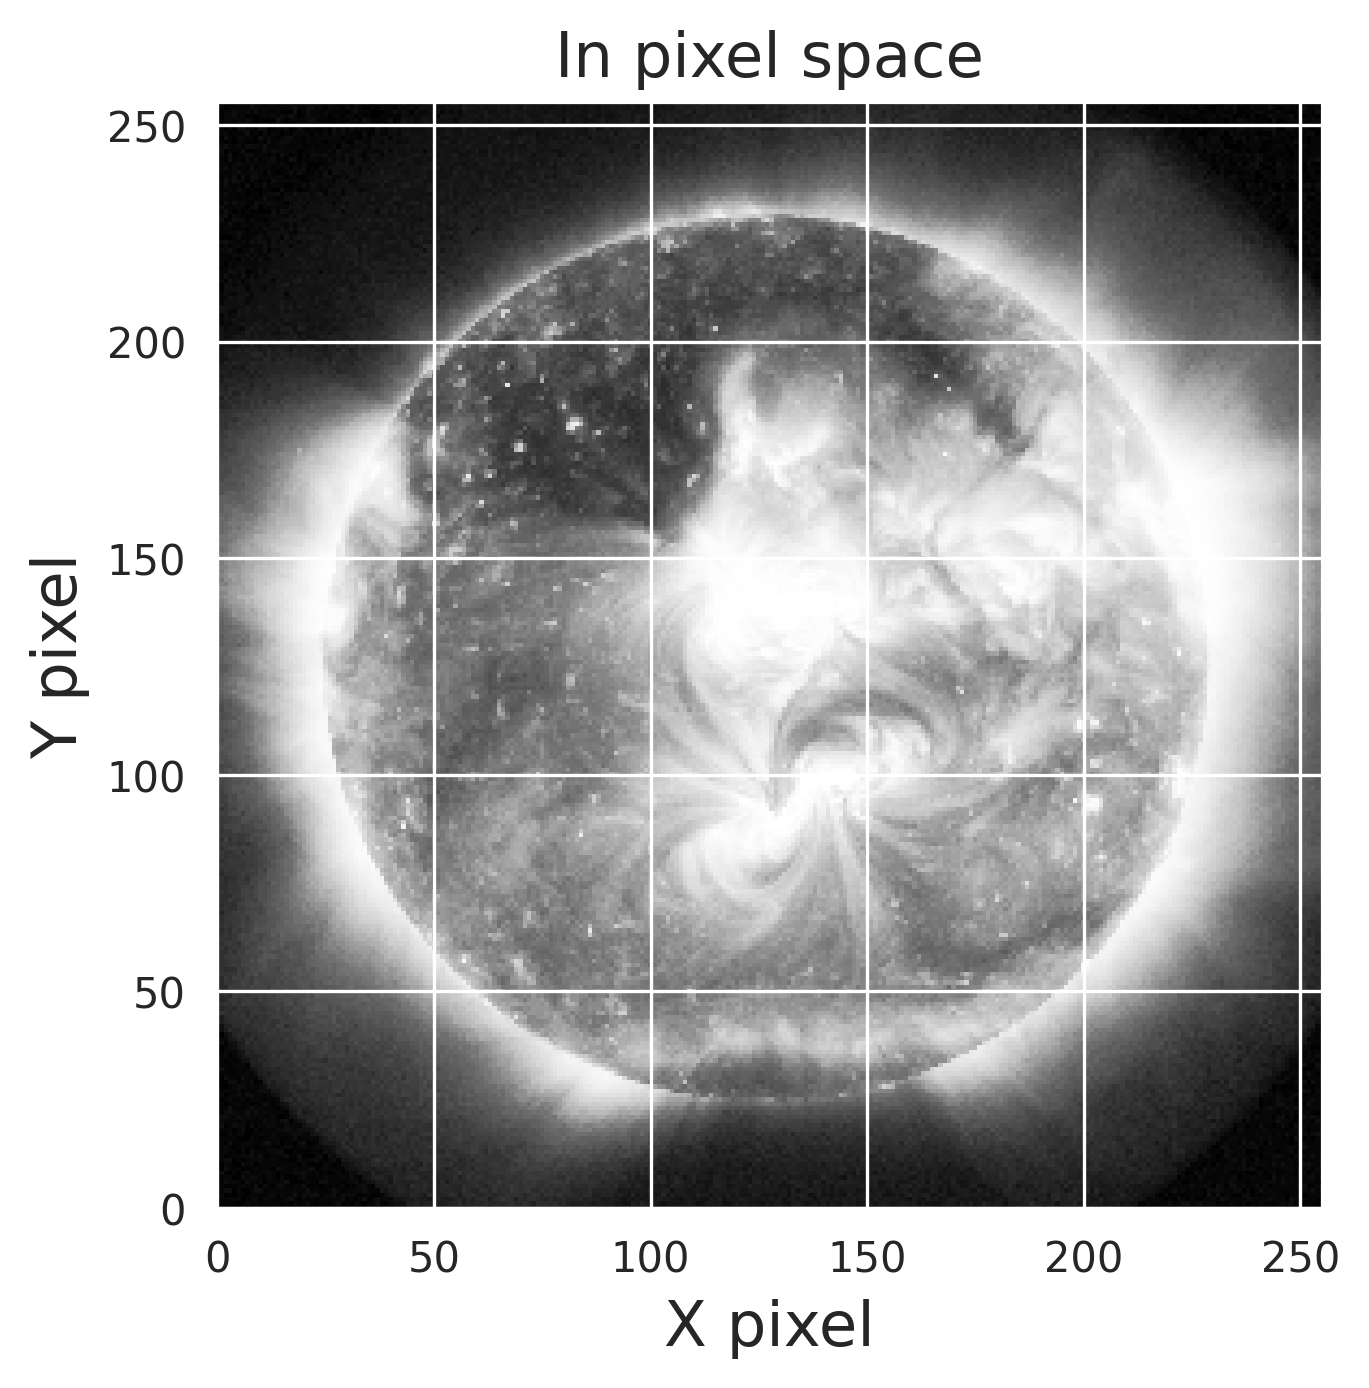
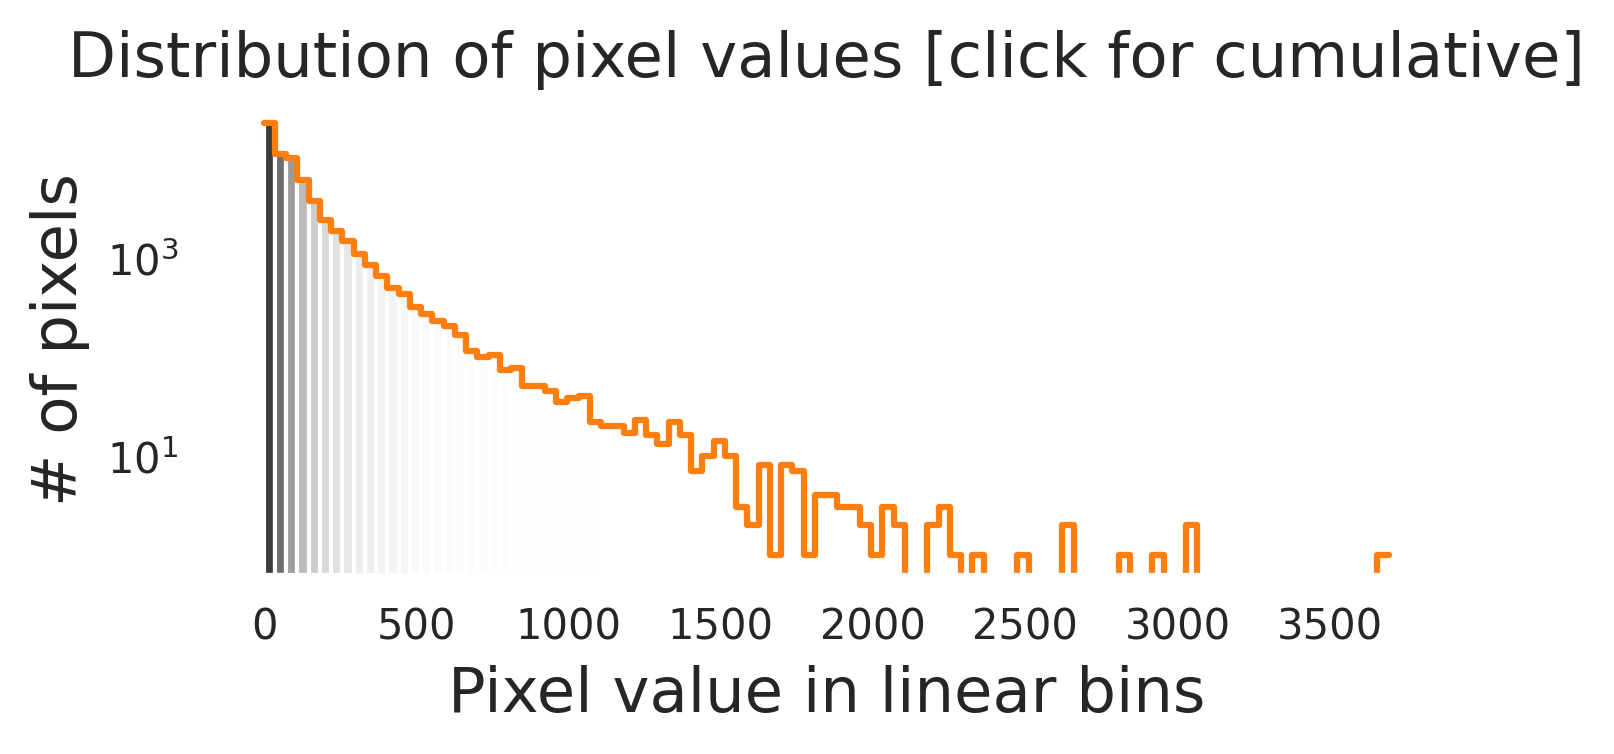
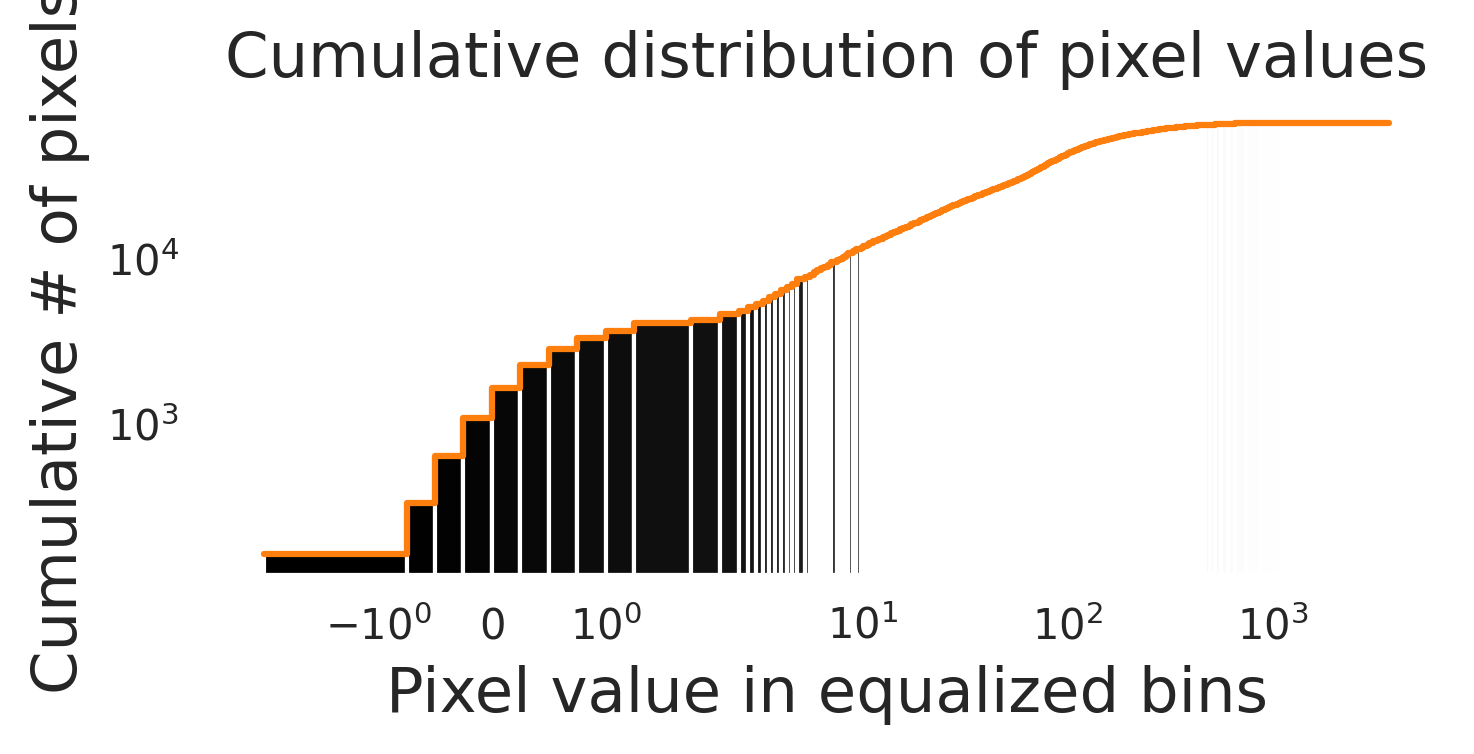

In [2]:
AIA211_2016 = sunpy.map.Map("data/aia_211A/2016*.fits")
AIA211_2016[0]

In [3]:
AIA211_2016_matrix = np.array(list(d.data for d in AIA211_2016))
AIA211_2016_matrix.shape

(2798, 256, 256)

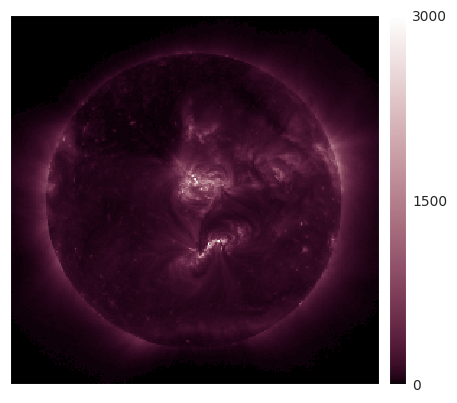

In [4]:
aia211_colormap = cm.color_tables.aia_color_table(211*u.angstrom)
isns.imshow(AIA211_2016_matrix[1], cmap=aia211_colormap, vmax=3000)
plt.show()

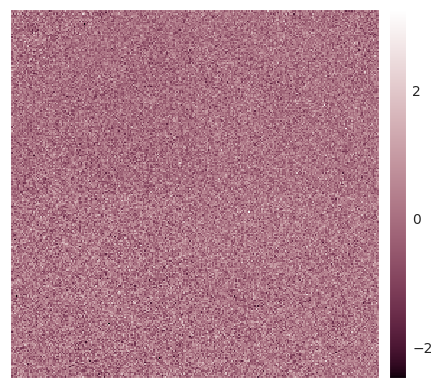

In [5]:
isns.imshow(AIA211_2016_matrix[6], cmap=aia211_colormap)
plt.show()

## Normalization

In [6]:
print(utils.range_tuple(AIA211_2016_matrix))
print(utils.range_tuple(AIA211_2016_matrix[8]))

(-32768.0, 15704.75)
(-2.0, 3316.75)


### To avoid outliers from messing with the normalization we clip the matrix

In [7]:
AIA211_2016_clipped = np.clip(AIA211_2016_matrix, 0, 3000)

In [8]:
min_values = AIA211_2016_clipped.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
print(min_values.shape)

max_values = AIA211_2016_clipped.max(axis=2, keepdims=True).max(axis=1, keepdims=True)
print(max_values.shape)

(2798, 1, 1)
(2798, 1, 1)


In [9]:
rg = max_values - min_values

rg = np.fmax(rg, 1e-4*np.ones(rg.shape))

AIA211_2016_mnorm = (AIA211_2016_clipped-min_values) / rg
utils.range_tuple(AIA211_2016_mnorm)

(0.0, 1.0)

In [10]:
AIA211_2016_bytes = np.round(AIA211_2016_mnorm*255).astype(np.uint8)
np.unique(AIA211_2016_bytes)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

# Comparison between the histogram of a good image and a noisy image

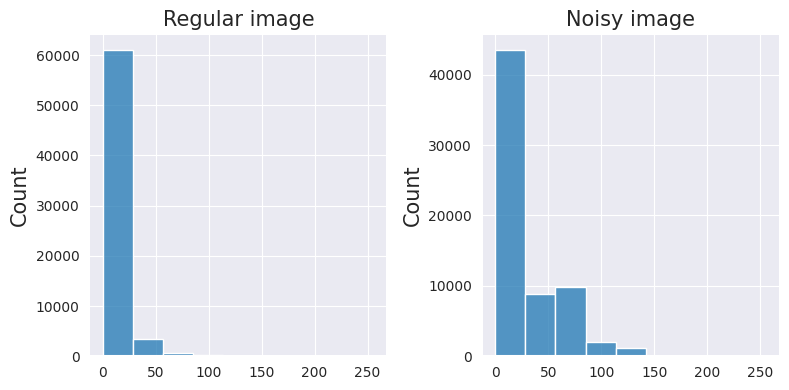

In [11]:
nbins = 10

fig, axes = plt.subplots(1, 2, figsize=(8, 4), gridspec_kw=dict(width_ratios=[4, 4]))

sns.histplot(AIA211_2016_bytes[0].flatten(), bins=np.linspace(0,256,nbins), ax=axes[0]).set(title="Regular image")

p = sns.histplot(AIA211_2016_bytes[6].flatten(), bins=np.linspace(0,256,nbins), ax=axes[1]).set(title="Noisy image")

fig.tight_layout()

## Noise detection model with kmeans

In [12]:
hist_vectors = np.array([np.histogram(i.flatten(), bins=np.linspace(0,256,nbins))[0] for i in AIA211_2016_bytes])

In [13]:
kmeans = KMeans(n_clusters=2, n_init=10)
kmeans.fit(hist_vectors/hist_vectors.max())
kmeans

KMeans(n_clusters=2)

### Visualization of each class

(2473, 256, 256)
(325, 256, 256)


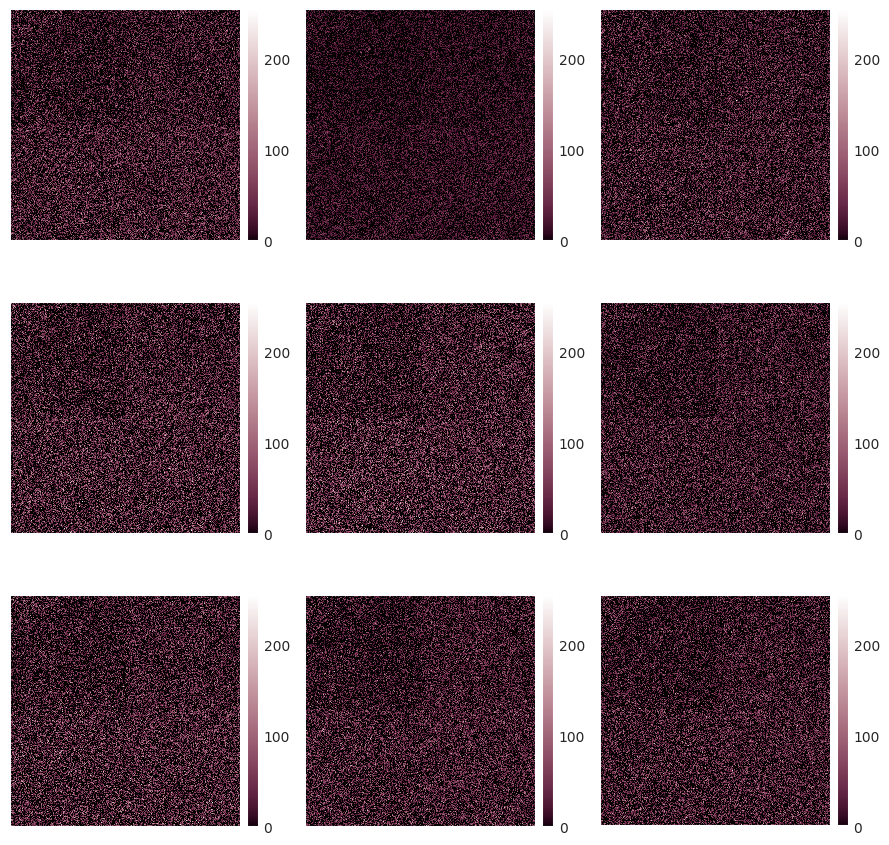

In [14]:
class1 = AIA211_2016_bytes[kmeans.labels_ == kmeans.labels_[0], :, :]  # since we know the first image is not noise
class2 = AIA211_2016_bytes[kmeans.labels_ != kmeans.labels_[0], :, :]
print(class1.shape)
print(class2.shape)
isns.ImageGrid([i for i in class2[:9]], cmap=aia211_colormap)
plt.show()

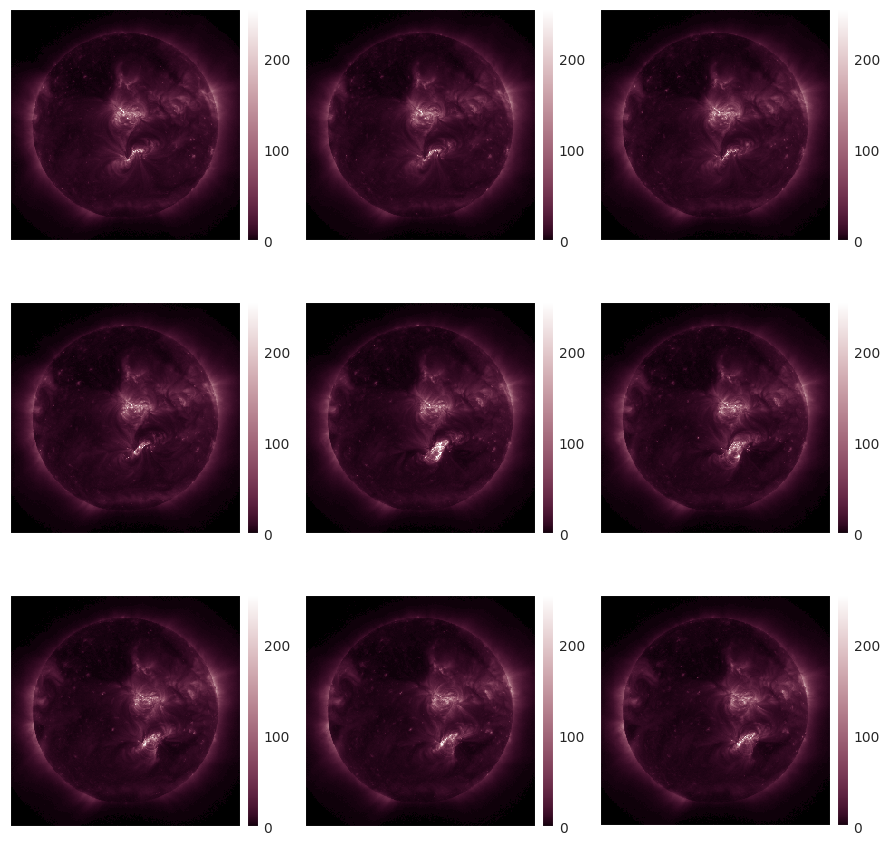

In [15]:
isns.ImageGrid([i for i in class1[:9]], cmap=aia211_colormap)
plt.show()

## We use the model to identify noisy images in the datase

In [43]:
file_list = []
kmeans_list = []

year_list = set(map(lambda x: x[:4], os.listdir("data/aia_211A")))

for year in year_list: 
    img_file_list = glob.glob(f"data/aia_211A/{year}*.fits")
    img_list = sunpy.map.Map(img_file_list)
    img_matrix = np.array(list(map(lambda x: x.data, img_list)))

    min_values = img_matrix.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
    max_values = img_matrix.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

    rg = max_values - min_values
    rg = np.fmax(rg, 1e-4*np.ones(rg.shape))

    img_norm = (img_matrix-min_values) / rg
    img_bytes = np.round(img_norm*255).astype(np.uint8)
    img_flat_array = img_bytes.reshape([img_bytes.shape[0], img_bytes.shape[1]*img_bytes.shape[2]])
    for j, img_flat in enumerate(img_flat_array):
        hist_array, _ = np.histogram(img_flat, bins=np.linspace(0,256,nbins))
        k = kmeans.predict(hist_array.reshape([1, -1]))[0]
        kmeans_list.append(k)
        if k != kmeans.labels_[0]:
            print(img_file_list[j])
            file_list.append(img_file_list[j])


data/aia_211A/2020-03-10T09-16-29.fits
data/aia_211A/2020-05-16T09-16-37.fits
data/aia_211A/2020-01-17T10-42-35.fits
data/aia_211A/2020-02-16T10-29-51.fits
data/aia_211A/2020-06-12T09-09-02.fits
data/aia_211A/2020-04-16T09-13-54.fits
data/aia_211A/2020-05-13T09-20-39.fits
data/aia_211A/2020-04-30T09-13-13.fits
data/aia_211A/2020-03-22T09-09-49.fits
data/aia_211A/2020-05-12T09-16-40.fits
data/aia_211A/2020-04-14T09-29-56.fits
data/aia_211A/2020-03-24T09-16-38.fits
data/aia_211A/2020-04-24T09-21-34.fits
data/aia_211A/2020-03-28T09-23-14.fits
data/aia_211A/2020-06-16T09-17-00.fits
data/aia_211A/2020-06-27T09-07-17.fits
data/aia_211A/2020-03-19T09-15-49.fits
data/aia_211A/2020-06-18T09-13-36.fits
data/aia_211A/2020-02-17T10-25-52.fits
data/aia_211A/2020-03-02T10-16-57.fits
data/aia_211A/2020-01-07T12-05-51.fits
data/aia_211A/2020-04-23T09-12-23.fits
data/aia_211A/2020-03-26T09-32-20.fits
data/aia_211A/2020-05-06T09-15-51.fits
data/aia_211A/2020-05-18T09-15-12.fits
data/aia_211A/2020-04-01T

### A sample of noisy images

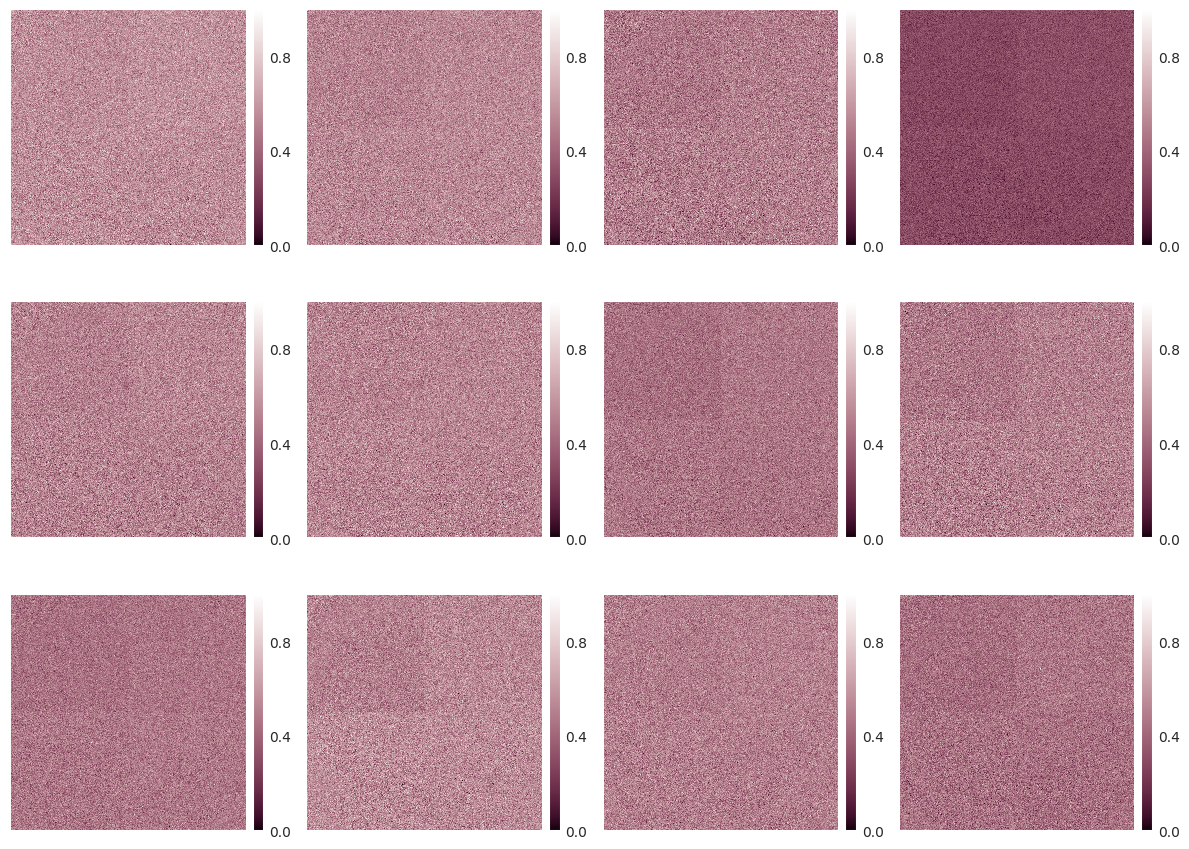

In [44]:
img_file_list = random.choices(file_list, k=12)
img_list = sunpy.map.Map(img_file_list)
img_matrix = np.array(list(map(lambda x: x.data, img_list)))

min_values = img_matrix.min(axis=2, keepdims=True).min(axis=1, keepdims=True)
max_values = img_matrix.max(axis=2, keepdims=True).max(axis=1, keepdims=True)

rg = max_values - min_values
rg = np.fmax(rg, 1e-4*np.ones(rg.shape))

img_norm = (img_matrix-min_values) / rg

isns.ImageGrid([i for i in img_norm], cmap=aia211_colormap, col_wrap=4)
plt.show()

In [45]:
with open("noisy_211A.csv", "w") as nf:
    for i in file_list:
        nf.write(i)
        nf.write("\n")